In [481]:
import sounddevice as sd
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

In [482]:
s, fs = sf.read("nagranie.wav", dtype=np.float32)
t=np.arange(0,s.shape[0]/fs,1/fs)*1000

In [483]:
#sd.play(s,fs)
#status=sd.wait()

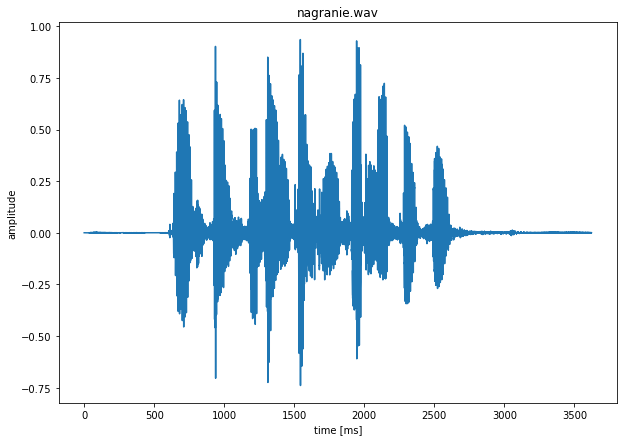

In [484]:
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.set_title("nagranie.wav")
ax.set_xlabel("time [ms]")
ax.set_ylabel("amplitude")
ax.plot(t,s)

plt.show()

# Frames

In [485]:
from sklearn import preprocessing
from numpy.lib.stride_tricks import sliding_window_view

def window(a, w = 4, o = 3, copy = True):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view

def frame(t, fs, s, dur, overlap=0):
    
    fms=fs/1000
    w=int(fms*dur)
    o=int(w*(1-overlap))
    
    windows=window(s,w=w,o=o)
    nframes=windows.shape[0]
    
    E=np.zeros(nframes)
    Z=np.zeros(nframes)
    
    for i in range(nframes):
        E[i]=energy(windows[i,:])
        Z[i]=zero_energy(windows[i,:])
        
    return preprocessing.normalize(E.reshape(1,nframes)).ravel(), preprocessing.normalize(Z.reshape(1,nframes)).ravel()
    
def energy(frame):
    E=np.power(frame,2).sum()
    return E

def zero_energy(frame):
    tmp=sliding_window_view(frame, window_shape = 2)
    tmp=tmp[:,0]*tmp[:,1]
    tmp=np.where(tmp>=0, 0, 1)
    tmp=tmp.sum()
    return tmp

def rysuj(dur,overl):
    for d in dur:
        for o in overl:
            E,Z=frame(t, fs, s, d, overlap=o)
            framet=np.linspace(0,t.max(),len(E))
            
            plt.figure(figsize=(10,7))
            
            plt.title(f"okno {d} ms\n overlap: {o}")
            plt.xlabel("time [ms]")
            plt.ylabel("amplitude")

            plt.plot(t,s,'c',label='signal')
            plt.plot(framet, E, linewidth=2, label='energy')
            plt.plot(framet, Z, linewidth=2, label='zero energy')

            plt.legend()

            plt.show()

# Porownanie dlugosci okien czasowych

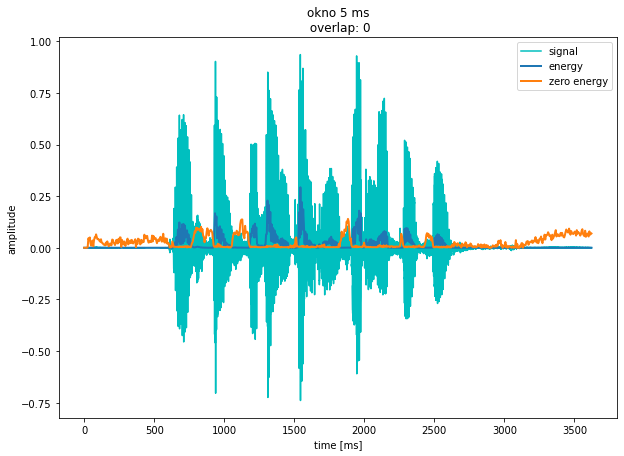

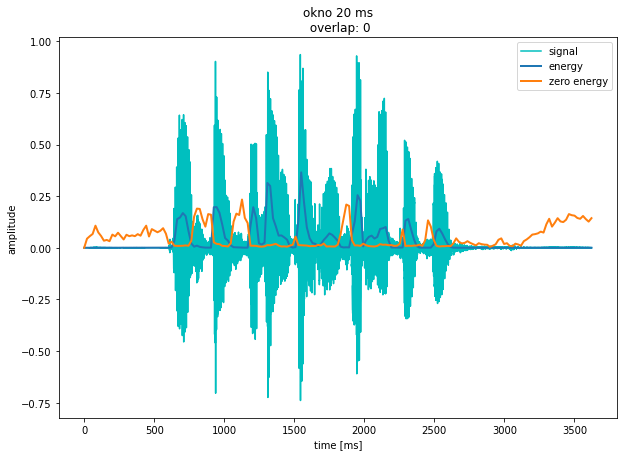

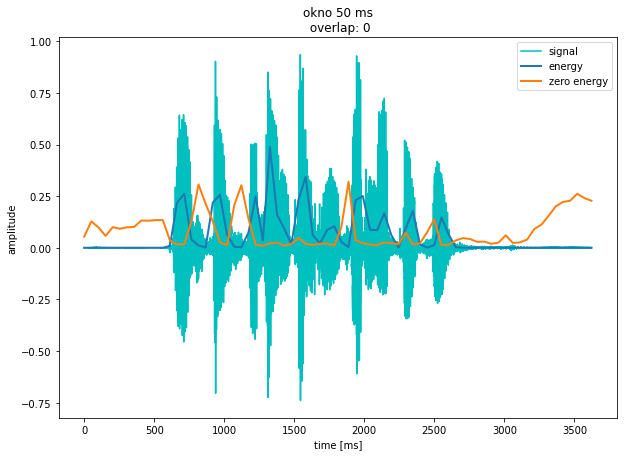

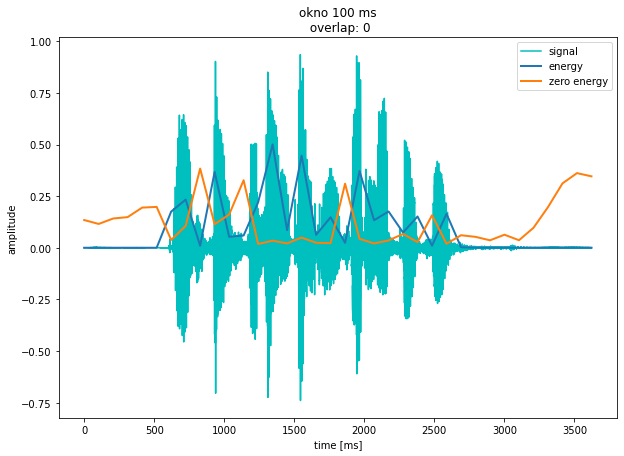

In [486]:
rysuj(dur=[5,20,50,100], overl=[0])

# Porownanie overapingu

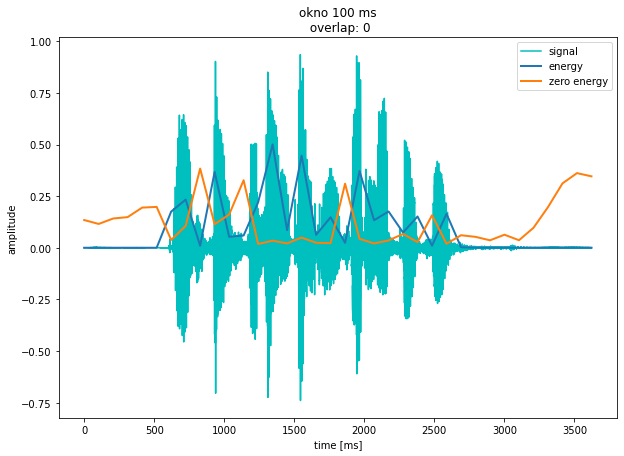

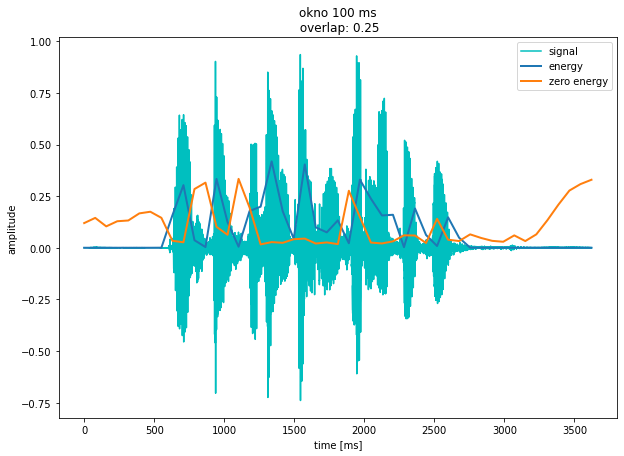

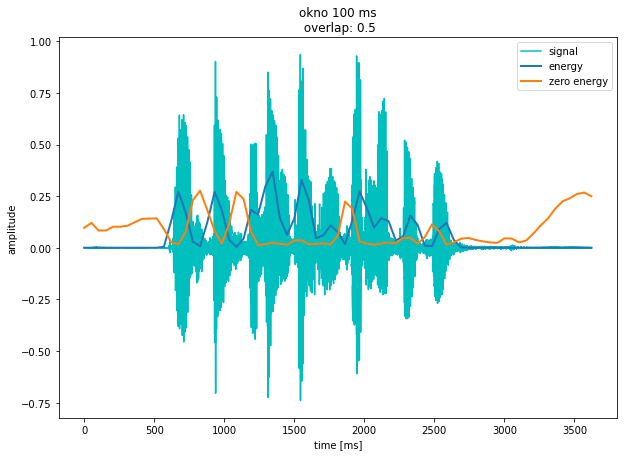

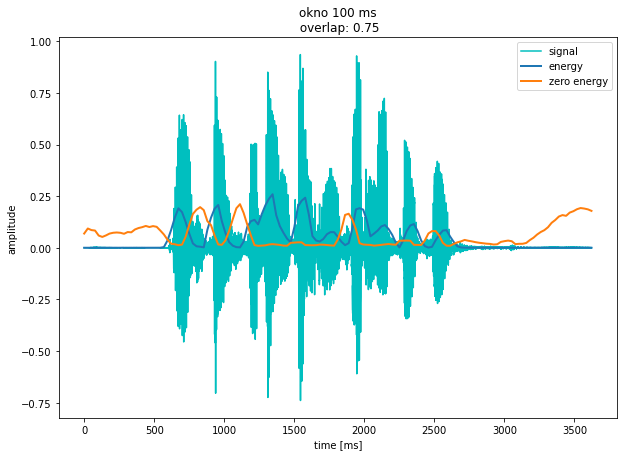

In [487]:
rysuj(dur=[100], overl=[0, 0.25, 0.5, 0.75])

Energia - spółgłoski<br>
Przejścia przez 0 - samogłoski

# Samogloska

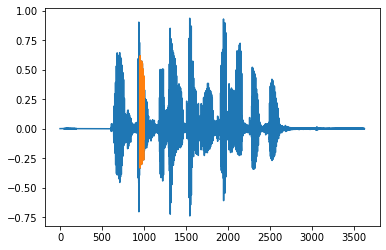

In [494]:
beg=42000
end=beg+2048

samogloska=s[beg:end]
t_samogloska=t[beg:end]

sd.play(samogloska,fs)

plt.plot(t,s)
plt.plot(t_samogloska,samogloska)

plt.show()

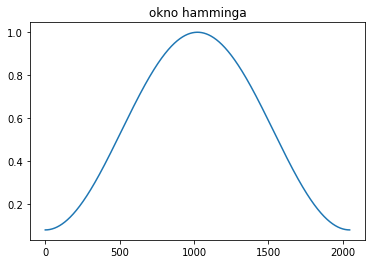

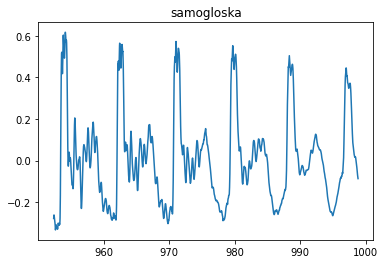

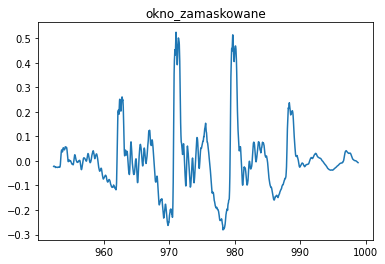

In [489]:
ham=np.hamming(2048)
okno_zamaskowane=samogloska*ham

plt.title("okno hamminga")
plt.plot(np.arange(0,len(ham)), ham)

plt.figure()
plt.title("samogloska")
plt.plot(t_samogloska, samogloska)

plt.figure()
plt.title("okno_zamaskowane")
plt.plot(t_samogloska, okno_zamaskowane)

plt.show()

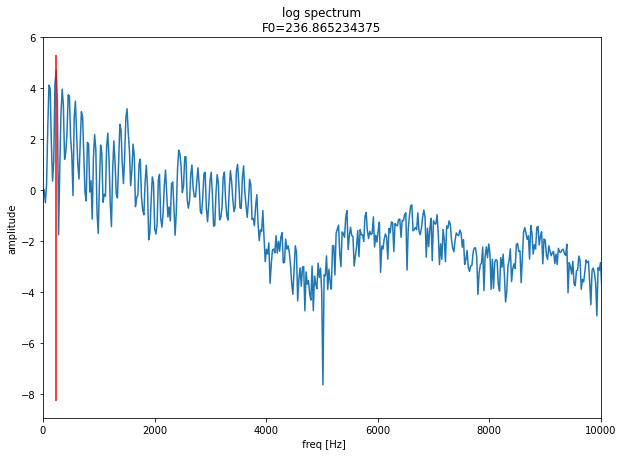

F0 = 236.865234375


In [490]:
import scipy.fftpack
def freq_scale(X,fs):
    N=len(X)
    tmp=np.arange(int(N),dtype=np.float64)
    return tmp*fs/N

yf=np.log(np.abs(scipy.fftpack.fft(okno_zamaskowane)))
x=freq_scale(np.arange(0,len(ham)), fs)
F0=x[yf.argmax()]

plt.figure(figsize=(10,7))
plt.title(f"log spectrum\nF0={F0}")
plt.xlabel(" freq [Hz]")
plt.ylabel("amplitude")
plt.plot(x,yf)
plt.xlim(0, 10000)
plt.vlines(F0, *plt.ylim(), 'r')

plt.show()

print(f"F0 = {F0}")

In [511]:
import librosa

okno=samogloska

a=librosa.lpc(okno, 20)
a=np.hstack([a,np.zeros(2048-a.size)])

C:\Users\mewash\AppData\Local\Temp\ipykernel_15464\3517149621.py:5: FutureWarning: Pass order=20 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  a=librosa.lpc(okno, 20)


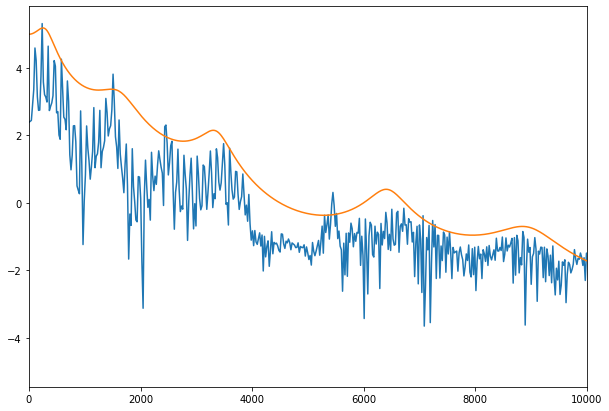

In [521]:
widmolpc=np.log(np.abs(scipy.fftpack.fft(a)))*-1
widmookno=np.log(np.abs(scipy.fftpack.fft(okno)))

x=freq_scale(np.arange(0,len(a)), fs)

plt.figure(figsize=(10,7))

plt.plot(x, widmookno)
plt.plot(x, widmolpc-1)
plt.xlim(0,10000)

plt.show()